<a href="https://colab.research.google.com/github/jjlopezre/Analitica-de-datos/blob/main/Copia_de_ej_mainfifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo completo para un problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/karangadiya/fifa19).

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2021-12-02 15:55:33--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 142.250.152.138, 142.250.152.113, 142.250.152.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3k-docs.googleusercontent.com/docs/securesc/v867jhu2kkbpvkcl67fj9m21dppftlqt/63s39ilgdngnjg3lcbpuotb3on8ff4uo/1638460500000/09173029842254050324/09703353611118942687Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2021-12-02 15:55:38--  https://doc-00-3k-docs.googleusercontent.com/docs/securesc/v867jhu2kkbpvkcl67fj9m21dppftlqt/63s39ilgdngnjg3lcbpuotb3on8ff4uo/1638460500000/09173029842254050324/09703353611118942687Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-00-3k-docs.googleusercontent.com (doc-00-3k-docs.googleusercontent.com)... 74.125.69.132, 2607:f8b0:4001:c08::84
Connecting 

# Lectura de la base de datos con Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [4]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros. No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/grid_search_cross_validation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones. En algunos textos, dado que se los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparametros respecto al conjunto de validación=evaluación). Sin embargo, la extensión anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AnaliticaDatos/blob/master/2_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: En este caso se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros. 

Se define el atributo Release Clause como salida.

In [5]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.5)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [6]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(9103,) (9104,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [7]:
print(ytrain[0],Xtrain.loc[0,"LS"])

€14.7M 88+2


In [8]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc 

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc   

In [9]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [10]:
ytrain_num[:5]

array([14700000.,  1600000.,   473000.,  4300000.,   464000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [11]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [12]:
Xdata['Nationality'].value_counts().index
Xdata['Nationality'].value_counts()

England        1662
Germany        1198
Spain          1072
Argentina       937
France          914
               ... 
Fiji              1
Guam              1
South Sudan       1
Liberia           1
Kuwait            1
Name: Nationality, Length: 164, dtype: int64

In [13]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [14]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y variables
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador
        
        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))
        
        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .       
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades 
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado
        
        return self    

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])
        
                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi
    
    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [15]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [16]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [17]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9103 entries, 701 to 12740
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9103 non-null   int64  
 1   Nationality               9103 non-null   float64
 2   Overall                   9103 non-null   int64  
 3   Potential                 9103 non-null   int64  
 4   Club                      9103 non-null   float64
 5   Value                     9103 non-null   float64
 6   Wage                      9103 non-null   float64
 7   Special                   9103 non-null   int64  
 8   Preferred Foot            9103 non-null   float64
 9   International Reputation  9103 non-null   float64
 10  Weak Foot                 9103 non-null   float64
 11  Skill Moves               9103 non-null   float64
 12  Work Rate                 9103 non-null   float64
 13  Body Type                 9103 non-null   float64
 14  Real 

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [18]:
corr_matrix = Xtrain_pre.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

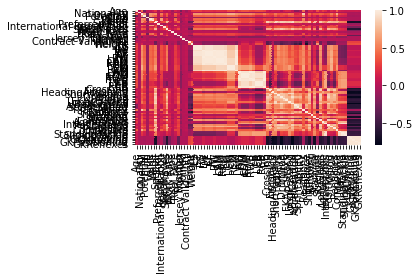

In [19]:
import seaborn as sns #librería útil para graficar mapas de calor, matrices
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values)
plt.tight_layout()
#sns.set(rc = {'figure.figsize':(35,12                                )})
plt.show()


# Ejercicio 1:

1. Qué puede discutir sobre las correlaciones cálculadas?
Con la correlacion calculada podemos filtrar que atributos estan mas relacionados entre si, lo que es muy útil para analizar los graficos con mayor sentido ya que debido al numero de atributos sería muy desgastante analizar cada atributo mientrasque asi se puede ir a la fija y hacer un análisis optimo de los atributos de interes de acuerdo al objetivo.
2. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?

Value, wage, International Reputation, Overall

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [20]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [21]:
Xm =pd.DataFrame(Xtrain_pre[['International Reputation', 'Value', 'Wage']],columns=['International Reputation', 'Value', 'Wage'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

In [22]:
corr_matrix = Xm.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

,International Reputation,Value,Wage,Output
International Reputation,1.000000,0.652547,0.673356,0.615426
Value,0.652547,1.000000,0.872763,0.969711
Wage,0.673356,0.872763,1.000000,0.833117
Output,0.615426,0.969711,0.833117,1.000000


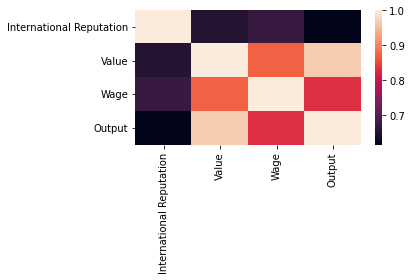

In [23]:
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values)
plt.tight_layout()
plt.show()

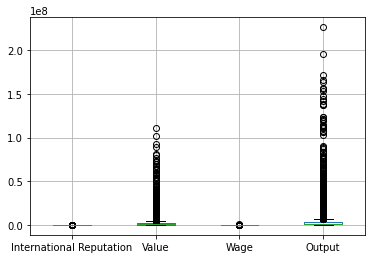

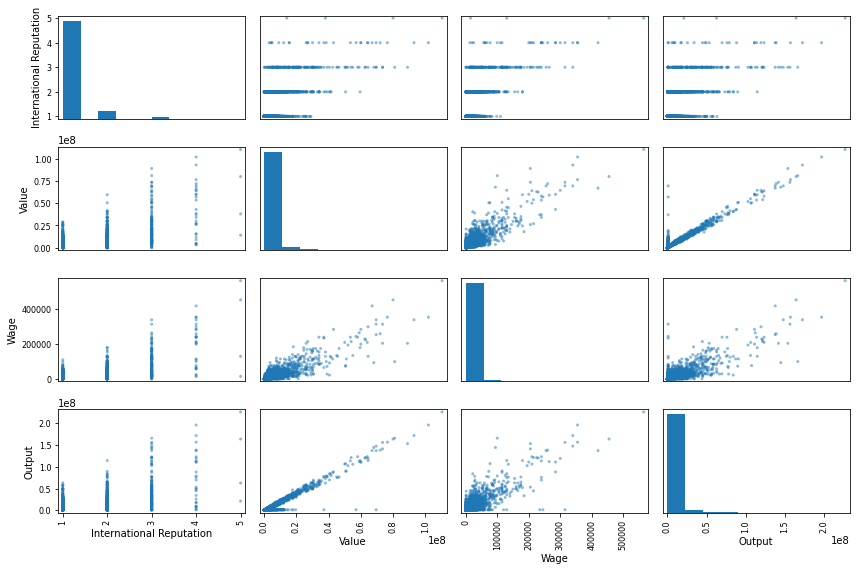

In [24]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

## datos preprocesados más StandardScaler

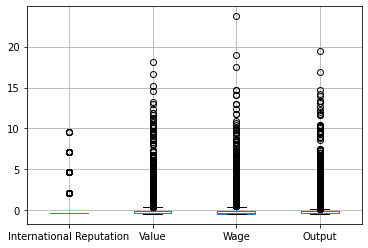

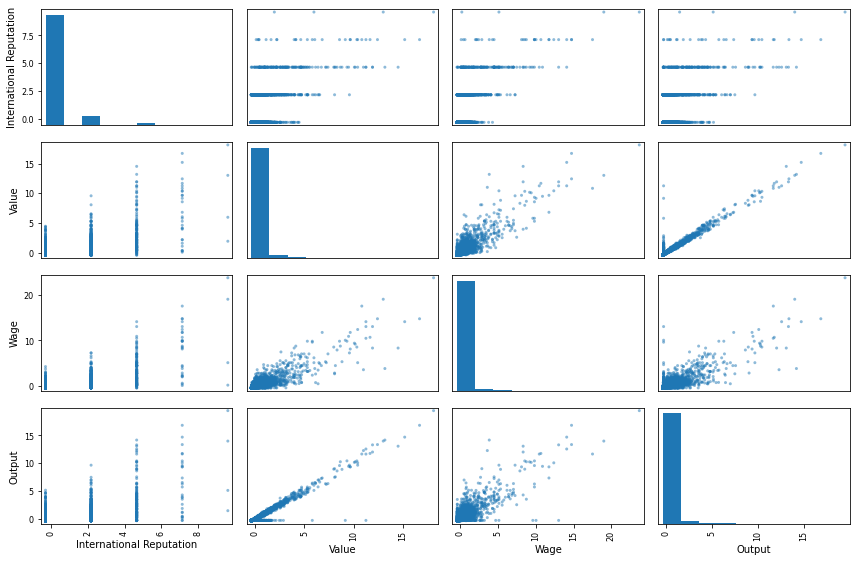

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xm)
Xm_nor = scaler.transform(Xm)

Xm_tr_num = pd.DataFrame(Xm_nor,columns=Xm.columns)

from pandas.plotting import scatter_matrix

Xm_tr_num.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_tr_num, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

## datos preprocesados más MinMaxscaler

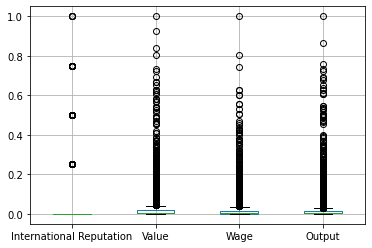

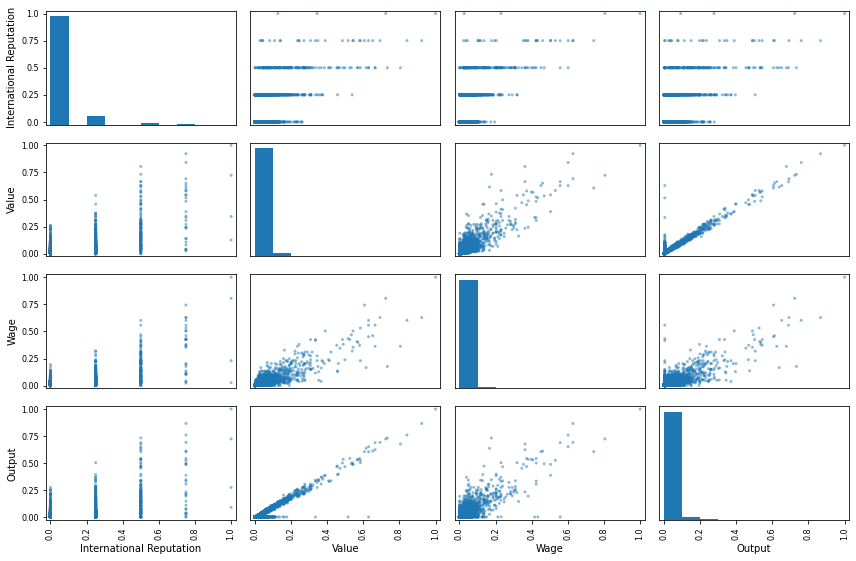

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Xm)
Xm_nor = scaler.transform(Xm)

Xm_tr_num = pd.DataFrame(Xm_nor,columns=Xm.columns)

from pandas.plotting import scatter_matrix

Xm_tr_num.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_tr_num, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)), 
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Courtois', 'Messi',
                                                   'Shaqiri',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'C. Ronaldo', 'Akinfenwa',
                                                   'Neymar'],
                                     'Club': ['AS Monaco', 'Burnley',
                                              'Borussia Dortmund', 'Arsenal',
                                              'Rayo Vallecano', 'Southampton',
                                              'Chelsea', 'Empoli',
                                              'Manchester City',
                                              'Tottenham Hotspur',
                                              'Manchester United',
                                              'Wo

In [28]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

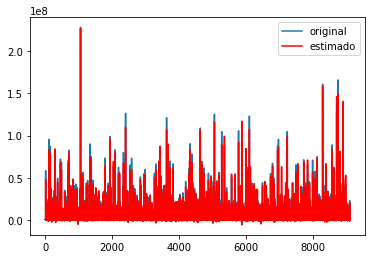

In [29]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

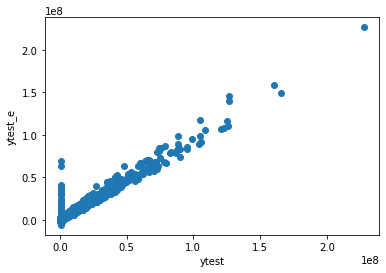

In [30]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



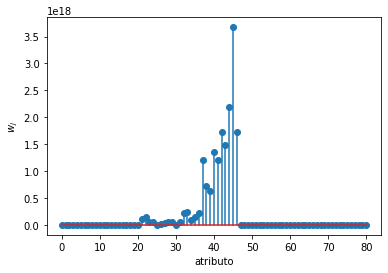

In [31]:
#Ayuda punto 1:
#el pipeline contiene el método steps codificando los elementos del proceso. 
#En este caso el regresor esta en la posición 2 y en la 1 de la tupla arrojada
#Revisando la documentación de LinearRegression, el atributo coef_ contiene las cargas del modelo
plt.stem(abs(metodo_full.steps[2][1].coef_))
plt.xlabel('atributo')
plt.ylabel('$w_j$')
plt.show()

La gráfica de los pesos muestran que tanta importancia presta a los atributos a pesar de que no están regularizados por eso se nota una gran diferencia entre los atributos aun asi se observa que hay atributos a los cuales no les presto importancia nuestro modelo

In [32]:
#Ayuda punto 2
#Dado que el preproceso no cambia, se sugiera generar el pipeline sin mypre_fifa para ahorrar tiempo
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) #pipeline a utilizar en el gridsearch
#Recuerde realizar el fit del gridsearch sobre las matrices de entrada y vector de salida preprocesados
#Xtrain_pre ytrain_num


In [33]:
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps)
metodo_gs.fit(Xtrain_pre,ytrain_num)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [34]:
ytest_e = metodo_gs.predict(Xtest_pre)

## Ejercicio 3.2

#Linear Regresor
Teniendo en cuenta que la pérdida es una medida de la diferencia existente entre los datos originales y la predicción, podemos definir la recta que mejor se ajusta a los datos como aquella que minimiza el error cuadrático medio.

Teniendo en cuenta que cada punto de la regresión se calcula como:

$\hat{y}_i = wx_i + b$

y reemplazando en la ecuación anterior, tenemos que el error cuadrático medio es:

$ECM = \displaystyle \frac{1}{N} \sum_{i=1}^{N}\left(y_i-wx_i-b\right)^2$

Por tanto, la Regresión Lineal es simplemente un problema de optimización, consistente en encontrar los valores w y b óptimos que minimizan la pérdida.
# Lasso
Problema de optimizacion 

$\min_{ \beta \in \mathbb{R}^p } \left\{ \frac{1}{N} \left\| y - X \beta \right\|_2^2 \right\} \text{ subject to } \| \beta \|_1 \leq t.$


la versión regularizada de lazo del estimador s es la solución  para
$\min_{ \alpha, \beta } \frac{1}{N} \sum_{i=1}^N f( x_i, y_i, \alpha, \beta ) \text{ subject to } \| \beta \|_1 \leq t$

#ElasticNet
ElasticNet es un modelo de regresión lineal entrenado con ambos $\ell_1$ y $\ell_2$ -Normalización de los coeficientes. Esta combinación permite aprender un modelo disperso donde algunos de los pesos son distintos de cero Lasso, mientras se mantienen las propiedades de regularización de Ridge. Controlamos la combinación convexa de $\ell_1$ y $\ell_2$ utilizando el l1_ratio

$\ min_ {w} {\frac {1} {2n _ {\text{muestras}}} || X w - y || _2 ^ 2 + \alpha \rho || w || _1 + \frac {\alpha (1- \rho)} {2} || w || _2 ^ 2}$

#KernelRidge

combina  Ridge regression y classification con kernel trick . De este modo, aprende una función lineal en el espacio inducida por el kernel respectivo y los datos. Para los núcleos no lineales, esto corresponde a una función no lineal en el espacio original.

La forma del modelo aprendido por KernelRidgees idéntica a la de soporte de regresión vectorial ( SVR). Sin embargo, se utilizan diferentes funciones de pérdida: KRR utiliza la pérdida de error al cuadrado mientras que la regresión vectorial de soporte utiliza-Pérdida insensible, ambas combinadas con regularización l2.

\begin{equation}
\omega^* = \arg\min_\omega \|y-\Phi \omega\|^2_2 + \alpha\|\omega\|^2_2
\end{equation}

\begin{equation}
\omega^* = (\Phi^\top \Phi+\alpha I)^{-1}\Phi^\top y
\end{equation}


\begin{equation}
\omega^* = \Phi^\top(\Phi \Phi^\top+\alpha I)^{-1}y = k(\cdot)^\top(K+\alpha I)^{-1}y
\end{equation}

#SGDRegressor
el gradiente de la pérdida se estima en cada muestra a la vez y el modelo se actualiza a lo largo del camino con un programa de fuerza decreciente (también conocido como tasa de aprendizaje).

El regularizador es una penalización agregada a la función de pérdida que reduce los parámetros del modelo hacia el vector cero utilizando la norma euclidiana al cuadrado L2 o la norma absoluta L1 o una combinación de ambas (Red elástica). Si la actualización del parámetro cruza el valor 0.0 debido al regularizador, la actualización se trunca a 0.0 para permitir el aprendizaje de modelos dispersos y lograr la selección de características en línea.

Esta implementación funciona con datos representados como matrices densas y numerosas de valores de punto flotante para las características.

#BayesianRidge
$p (y | X, w, \ alpha) = \mathcal {N} (y | X w, \ alpha)$

BayesianRidge estima un modelo probabilístico del problema de regresión como se describió anteriormente. El anterior para el coeficiente $\omega$ está dado por un gaussiano esférico:

$p(w|\lambda) =\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})$

Los parametros $\omega$,$\alpha$  y $\lambda$ se estiman conjuntamente durante el ajuste del modelo, los parámetros de regularización $\alpha$  y $\lambda$ siendo estimado maximizando la probabilidad marginal logarítmica

# Ejercicio 3.3
## LinearRegresor

In [35]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             Xtrain_pre,
                             ytrain_num,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [36]:
# Train model
lr = LinearRegression().fit(Xtrain_pre, ytrain_num)
# get cross val scores
get_cv_scores(lr)


CV Mean:  0.946325134875791
STD:  0.027139520320924326




## Lasso

In [41]:
from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(Xtrain_pre, ytrain_num)
# get cross val scores
get_cv_scores(lasso)

CV Mean:  0.9463193113822136
STD:  0.027143887046019815




In [42]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=10, n_jobs=4)
grid_result = grid.fit(Xtrain_pre, ytrain_num)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.9463312860440862
Best Params:  {'alpha': 1000}


### ElasticNet

In [43]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(Xtrain_pre, ytrain_num)
# get cross val scores
get_cv_scores(elastic_net)


CV Mean:  0.9462410507954756
STD:  0.027012429473195307




In [44]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=4)
grid_result = grid.fit(Xtrain_pre, ytrain_num)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best Score:  0.9463312860440862
Best Params:  {'alpha': 1000, 'l1_ratio': 1}


### Kernelridge

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [1e-3,1e-2,1e-1,1,10],              
              'reg__gamma': [1e-3,1e-2,1e-1,1,10],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=5,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(Xtrain_pre, ytrain_num)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Mejores parámetros:

{'reg__alpha': 0.001, 'reg__gamma': 0.001}


### SGDREGRESSOR

In [48]:
 from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.0001, l1_ratio=0.15).fit(Xtrain_pre, ytrain_num)
# get cross val scores
get_cv_scores(sgd)

CV Mean:  -5.545030521787667e+31
STD:  6.105769026015038e+31




In [49]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=sgd, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=4)
grid_result = grid.fit(Xtrain_pre, ytrain_num)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best Score:  -2.539303574224081e+29
Best Params:  {'alpha': 1000, 'l1_ratio': 0.3}


### BayesianRidge

In [ ]:
from sklearn import linear_model

steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion', linear_model.BayesianRidge()) #ajustar según ejercicio
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos
pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=5,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

grid_search.fit(Xtrain_pre, ytrain_num)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)



In [50]:
 from sklearn import linear_model
bayesianridge= linear_model.BayesianRidge().fit(Xtrain_pre, ytrain_num)
# get cross val scores
get_cv_scores(bayesianridge)

CV Mean:  0.9448982904864354
STD:  0.026312545255740543




In [55]:
alpha_init = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
lambda_init = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]
param_grid = dict(alpha_init=alpha_init, lambda_init= lambda_init)
grid = GridSearchCV(estimator=bayesianridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=4)
grid_result = grid.fit(Xtrain_pre, ytrain_num)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best Score:  0.9458119887172
Best Params:  {'alpha_init': 0.1, 'lambda_init': 1e-09}
